In [ ]:

!pip install torch
!pip install swig
!pip install gymnasium
!pip install "gymnasium[box2d]"
!pip install matplotlib
!pip install imageio



In [2]:
!# Imports
from typing import Iterable
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import copy
import numpy as np
import pandas as pd
import random
from PIL import Image
import gymnasium as gym
import matplotlib.pyplot as plt
from typing import Callable
from collections import namedtuple
import itertools


from google.colab import drive

drive.mount('/content/drive')




Mounted at /content/drive


In [3]:
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("GPU Available!")
else:
  device = torch.device("cpu")
  print("USE CPU")



GPU Available!


In [16]:
class Critic(nn.Module):
    def __init__(self, obs_dim: int, action_dim: int):
        """
        Initialize the Critic network.

        :param obs_dim: dimention of the observations
        :param num_actions: dimention of the actions
        """
        super(Critic, self).__init__()


        self.conv1 = nn.Conv2d(3  , 32 , 3 ,  1 ,1 )
        self.conv2 = nn.Conv2d(32 , 64, 3 ,  1 ,1 )


        self.fc1 = nn.Linear(64 * 24 *24  + action_dim , 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 1)
        self.relu = nn.ReLU()



    def forward(self, obs: torch.Tensor, action: torch.Tensor) -> torch.Tensor:

        x = obs.permute(0,3, 1, 2)
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))

        flatx = nn.Flatten()
        x = flatx(x)

        x = torch.cat([x, action], dim=1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        out = x
        return out


In [15]:
class Actor(nn.Module):
    def __init__(self, obs_dim: int, action_dim: int, action_low: np.array, action_high: np.array):
        """
        Initialize the Actor network.

        :param obs_dim: dimention of the observations
        :param num_actions: dimention of the actions
        """
        super(Actor, self).__init__()
        # We are registering scale and bias as buffers so they can be saved and loaded as part of the model.
        # Buffers won't be passed to the optimizer for training!
        self.register_buffer(
            "action_scale", torch.tensor((action_high - action_low) / 2.0, dtype=torch.float32)
        )
        self.register_buffer(
            "action_bias", torch.tensor((action_high + action_low) / 2.0, dtype=torch.float32)
        )


        self.conv1 = nn.Conv2d(3  , 32 , 3 ,  1 ,1 )
        self.conv2 = nn.Conv2d(32 , 64, 3 ,  1 , 1 )


        self.fc1 = nn.Linear(64 * 24 * 24  , 256)
        self.fc_mu = nn.Linear(256, action_dim)
        self.fc_std = nn.Linear(256, action_dim)
        self.relu = nn.ReLU()


    def forward(self, obs: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass of the actor network.

        return: mean_action, log_prob_action
        """


        x = obs.permute(0,3,1,2)
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))

        flatx = nn.Flatten()
        x = flatx(x)

        x = F.relu(self.fc1(x))
        mu = F.relu(self.fc_mu(x))
        std = F.softplus(self.fc_std(x))


        dist = torch.distributions.Normal(mu, std)

        action = dist.rsample()

        log_prob = dist.log_prob(action)


        # Enforcing action bounds
        adjusted_action = torch.tanh(action) * self.action_scale + self.action_bias
        adjusted_log_prob = log_prob - torch.log(self.action_scale * (1-torch.tanh(action).pow(2)) + 1e-6)

        return adjusted_action, adjusted_log_prob



In [6]:
class ReplayBuffer:
    def __init__(self, max_size: int):
        """
        Create the replay buffer.

        :param max_size: Maximum number of transitions in the buffer.
        """
        self.data = []
        self.max_size = max_size
        self.position = 0

    def __len__(self) -> int:
        """Returns how many transitions are currently in the buffer."""
        return len(self.data)

    def store(self, obs: torch.Tensor, action: torch.Tensor, reward: torch.Tensor, next_obs: torch.Tensor, terminated: torch.Tensor):
        """
        Adds a new transition to the buffer. When the buffer is full, overwrite the oldest transition.

        :param obs: The current observation.
        :param action: The action.
        :param reward: The reward.
        :param next_obs: The next observation.
        :param terminated: Whether the episode terminated.
        """
        if len(self.data) < self.max_size:
            self.data.append((obs, action, reward, next_obs, terminated))
        else:
            self.data[self.position] = (obs, action, reward, next_obs, terminated)
        self.position = (self.position + 1) % self.max_size

    def sample(self, batch_size: int) -> torch.Tensor:
        """
        Sample a batch of transitions uniformly and with replacement. The respective elements e.g. states, actions, rewards etc. are stacked

        :param batch_size: The batch size.
        :returns: A tuple of tensors (obs_batch, action_batch, reward_batch, next_obs_batch, terminated_batch), where each tensors is stacked.
        """
        return [torch.stack(b) for b in zip(*random.choices(self.data, k=batch_size))]

In [14]:
def update_critics(
        q1: nn.Module,
        q1_target: nn.Module,
        q1_optimizer: optim.Optimizer,
        q2: nn.Module,
        q2_target: nn.Module,
        q2_optimizer: optim.Optimizer,
        actor_target: nn.Module,
        log_ent_coef: torch.Tensor,
        gamma: float,
        obs: torch.Tensor,
        act: torch.Tensor,
        rew: torch.Tensor,
        next_obs: torch.Tensor,
        tm: torch.Tensor,
    ):
    """
    Update both of SAC's critics for one optimizer step.

    :param q1: The first critic network.
    :param q1_target: The target first critic network.
    :param q1_optimizer: The first critic's optimizer.
    :param q2: The second critic network.
    :param q2_target: The target second critic network.
    :param q2_optimizer: The second critic's optimizer.
    :param actor: The actor network.
    :param actor_target: The target actor network.
    :param actor_optimizer: The actor's optimizer.
    :param gamma: The discount factor.
    :param obs: Batch of current observations.
    :param act: Batch of actions.
    :param rew: Batch of rewards.
    :param next_obs: Batch of next observations.
    :param tm: Batch of termination flags.

    """
    #Calculate the target
    with torch.no_grad():
         act_target , next_act_log_prob  =  actor_target(next_obs)
         act_target  = act_target.to(device)

         ent_term =  -torch.mean(torch.sum(torch.exp(next_act_log_prob)  * next_act_log_prob ,dim =1 )  )

         entropy =  - log_ent_coef.exp() * ent_term

         min_q  = torch.min(q2_target(next_obs,  act_target) , q1_target(next_obs,  act_target))
         min_q = min_q.squeeze(1)


         target_q  = rew   +    gamma * ( min_q  + entropy )  * (1 - tm.float())

         target_q = target_q.to(device)


    #Update both q function using our target
    for q, optimizer in [(q1, q1_optimizer), (q2, q2_optimizer)]:

        critic_loss =  F.mse_loss(  q1(obs , act).squeeze(1) , target_q)   +   F.mse_loss(  q2(obs , act).squeeze(1) , target_q)
        optimizer.zero_grad()
        critic_loss.backward()
        optimizer.step()


def update_actor(
    q1: nn.Module,
    q2: nn.Module,
    actor: nn.Module,
    actor_optimizer: optim.Optimizer,
    obs: torch.Tensor,
    log_ent_coef: torch.Tensor,
    action: torch.Tensor,
    action_log_prob: torch.Tensor,
    ):
    """
    Update the SAC's Actor network for one optimizer step.

    :param critic: The critic network.
    :param actor: The actor network.
    :param actor_optimizer: The actor's optimizer.
    :param obs: Batch of current observations.
    :param action: action calculated
    :param action_log_prob: log probabilty of action

    """
    # Actor Update

   # action , action_log_prob = actor(obs)

    entropy =  - log_ent_coef.exp() * action_log_prob

    q1, q2 = q1(obs, action), q2(obs, action)
    q1_q2 = torch.cat([q1, q2], dim=1)
    min_q = torch.min(q1_q2, 1, keepdim=True)[0]

    actor_loss = (- min_q - entropy).mean()

    actor_optimizer.zero_grad()
    actor_loss.backward()
    actor_optimizer.step()

def update_entropy_coefficient(
        actor: nn.Module,
        log_ent_coef: torch.Tensor,
        target_entropy: float,
        ent_coef_optimizer: optim.Optimizer,
        obs: torch.Tensor,
        action_log_prob: torch.Tensor
    ):
    """
    Automatic update for entropy coefficient (alpha)

    :param actor: the actor network.
    :param log_ent_coef: tensor representing the log of entropy coefficient (log_alpha).
    :param target_entropy: tensor representing the desired target entropy.
    :param ent_coef_optimizer: torch optimizer for entropy coefficient.
    :param obs: current batch observation.
    :param action_log_prob: log probability
    """


   # _, action_log_prob = actor(obs)


    ent_coef_loss = -(log_ent_coef.exp() * (action_log_prob + target_entropy).detach()).mean()
    ent_coef_optimizer.zero_grad()
    ent_coef_loss.backward()
    ent_coef_optimizer.step()


In [8]:
def polyak_update(
    params: Iterable[torch.Tensor],
    target_params: Iterable[torch.Tensor],
    tau: float,
) -> None:
    """
    Perform a Polyak average update on ``target_params`` using ``params``:

    :param params: parameters of the original network (model.parameters())
    :param target_params: parameters of the target network (model_target.parameters())
    :param tau: the soft update coefficient ("Polyak update", between 0 and 1) 1 -> Hard update, 0 -> No update
    """
    with torch.no_grad():
        for param, target_param in zip(params, target_params):
            target_param.data.mul_(1 - tau)
            torch.add(target_param.data, param.data, alpha=tau, out=target_param.data)

In [38]:
EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards"])


class SACAgent:
    def __init__(self,
            env,
            gamma=0.99,
            lr=0.001,
            batch_size=64,
            tau=0.005,
            maxlen=100_000,
            target_entropy=-1.0,
        ):
        """
        Initialize the SAC agent.

        :param env: The environment.
        :param exploration_noise.
        :param gamma: The discount factor.
        :param lr: The learning rate.
        :param batch_size: Mini batch size.
        :param tau: Polyak update coefficient.
        :param max_size: Maximum number of transitions in the buffer.
        """

        self.env = env
        self.gamma = gamma
        self.batch_size = batch_size
        self.tau = tau
        self.target_entropy=target_entropy

        # Initialize the Replay Buffer
        self.buffer = ReplayBuffer(maxlen)

        # Initialize two critic and one actor network


        obs_shape = int(env.observation_space.shape[0])
        print(f'obs shape {obs_shape} ')
        act_shape = int(env.action_space.shape[0])
        print(f'actor shape {act_shape} ')

        self.q1 = Critic(obs_shape, act_shape).to(device)
        self.q2 = Critic(obs_shape, act_shape).to(device)
        self.actor = Actor(obs_shape, act_shape, env.action_space.low , env.action_space.high).to(device)
        self.log_ent_coef = torch.zeros(1, requires_grad=True)



        # Initialze two target critic and one target actor networks and load the corresponding state_dicts
        self.q1_target = Critic(obs_shape, act_shape).to(device)
        self.q1_target.load_state_dict(self.q1.state_dict())
        self.q2_target = Critic(obs_shape, act_shape).to(device)
        self.q2_target.load_state_dict(self.q2.state_dict())
        self.actor_target =  Actor(obs_shape, act_shape, env.action_space.low , env.action_space.high).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())

        # Create ADAM optimizer for the Critic and Actor networks
        self.q1_optimizer = optim.Adam(self.q1.parameters(), lr=lr)
        self.q2_optimizer =  optim.Adam(self.q2.parameters(), lr=lr)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr)
        self.ent_coef_optimizer = optim.Adam([self.log_ent_coef], lr=lr)

        self.log_ent_coef  =  self.log_ent_coef.to(device)



        #################################################################################################################
        #Inititialise the files to store the data in case of disruptions. Comment this out after training has started else file will overwrite
        #If you are retraining from the start, uncomment this and run training loop twice to clear all data



        episode_lengths=torch.zeros(1000)
        episode_rewards=torch.zeros(1000)
        i_episode = 0
        current_timestep = 0

        torch.save(episode_lengths  ,  f"/content/drive/MyDrive/car_racer/episode_lengths.pth"  )
        torch.save(episode_rewards  ,  f"/content/drive/MyDrive/car_racer/episode_rewards.pth"  )
        torch.save(i_episode  ,  f"/content/drive/MyDrive/car_racer/i_episode.pth"  )
        torch.save(current_timestep  ,  f"/content/drive/MyDrive/car_racer/current_timestep.pth"  )
        torch.save(self.actor   ,  f"/content/drive/MyDrive/car_racer/actor.pth"  )
        torch.save(self.q1   ,  f"/content/drive/MyDrive/car_racer/q1.pth"  )
        torch.save(self.q2   ,  f"/content/drive/MyDrive/car_racer/q2.pth"  )
        torch.save(self.q1_target   ,  f"/content/drive/MyDrive/car_racer/q1_target.pth"  )
        torch.save(self.q2_target   ,  f"/content/drive/MyDrive/car_racer/q2_target.pth"  )
        torch.save(self.actor_target   ,  f"/content/drive/MyDrive/car_racer/actor_target.pth"  )
        torch.save(self.q1_optimizer  ,  f"/content/drive/MyDrive/car_racer/q1_optimizer.pth"  )
        torch.save(self.q2_optimizer   ,  f"/content/drive/MyDrive/car_racer/q2_optimizer.pth"  )
        torch.save(self.actor_optimizer   ,  f"/content/drive/MyDrive/car_racer/actor_optimizer.pth"  )
        torch.save(self.ent_coef_optimizer   ,  f"/content/drive/MyDrive/car_racer/ent_coef_optimizer.pth"  )
        torch.save(self.log_ent_coef   ,  f"/content/drive/MyDrive/car_racer/log_ent_coef.pth"  )




        ################################################################################################################





    def train(self, num_episodes: int) -> EpisodeStats:
        """
        Train the SAC agent.

        :param num_episodes: Number of episodes to train.
        :returns: The episode statistics.
        """

        episode_lengths =  torch.load(  f"/content/drive/MyDrive/car_racer/episode_lengths.pth"  )
        episode_rewards  =  torch.load( f"/content/drive/MyDrive/car_racer/episode_rewards.pth"  )
        i_episode  =  torch.load( f"/content/drive/MyDrive/car_racer/i_episode.pth"  )
        current_timestep  =  torch.load( f"/content/drive/MyDrive/car_racer/current_timestep.pth"  )
        self.actor  =  torch.load(  f"/content/drive/MyDrive/car_racer/actor.pth"  )
        self.q1   = torch.load(  f"/content/drive/MyDrive/car_racer/q1.pth"  )
        self.q2 = torch.load(  f"/content/drive/MyDrive/car_racer/q2.pth"  )
        self.q1_target  = torch.load(  f"/content/drive/MyDrive/car_racer/q1_target.pth"  )
        self.q2_target  =  torch.load( f"/content/drive/MyDrive/car_racer/q2_target.pth"  )
        self.actor_target    = torch.load(  f"/content/drive/MyDrive/car_racer/actor_target.pth"  )

        self.q1_optimizer  = torch.load(  f"/content/drive/MyDrive/car_racer/q1_optimizer.pth"  )
        self.q2_optimizer   = torch.load(  f"/content/drive/MyDrive/car_racer/q2_optimizer.pth"  )
        self.actor_optimizer  =  torch.load( f"/content/drive/MyDrive/car_racer/actor_optimizer.pth"  )
        self.ent_coef_optimizer   = torch.load(  f"/content/drive/MyDrive/car_racer/ent_coef_optimizer.pth"  )
        self.log_ent_coef = torch.load(  f"/content/drive/MyDrive/car_racer/log_ent_coef.pth"  )


        episode_time = 0


        for i_episode in range(i_episode , num_episodes):
            # Print out which episode we're on, useful for debugging.
            print(f"episode:", i_episode)

            if (i_episode + 1) % 10 == 0:               #Saves the parameters every 10 episodes
                print(f'Episode {i_episode + 1} of {num_episodes}  Time Step: {current_timestep}')
                torch.save(episode_lengths  ,  f"/content/drive/MyDrive/car_racer/episode_lengths.pth"  )
                torch.save(episode_rewards  ,  f"/content/drive/MyDrive/car_racer/episode_rewards.pth"  )
                torch.save(i_episode  ,  f"/content/drive/MyDrive/car_racer/i_episode.pth"  )
                torch.save(current_timestep  ,  f"/content/drive/MyDrive/car_racer/current_timestep.pth"  )
                torch.save(self.actor   ,  f"/content/drive/MyDrive/car_racer/actor.pth"  )
                torch.save(self.q1   ,  f"/content/drive/MyDrive/car_racer/q1.pth"  )
                torch.save(self.q2   ,  f"/content/drive/MyDrive/car_racer/q2.pth"  )
                torch.save(self.q1_target   ,  f"/content/drive/MyDrive/car_racer/q1_target.pth"  )
                torch.save(self.q2_target   ,  f"/content/drive/MyDrive/car_racer/q2_target.pth"  )
                torch.save(self.actor_target   ,  f"/content/drive/MyDrive/car_racer/actor_target.pth"  )
                torch.save(self.q1_optimizer  ,  f"/content/drive/MyDrive/car_racer/q1_optimizer.pth"  )
                torch.save(self.q2_optimizer   ,  f"/content/drive/MyDrive/car_racer/q2_optimizer.pth"  )
                torch.save(self.actor_optimizer   ,  f"/content/drive/MyDrive/car_racer/actor_optimizer.pth"  )
                torch.save(self.ent_coef_optimizer   ,  f"/content/drive/MyDrive/car_racer/ent_coef_optimizer.pth"  )
                torch.save(self.log_ent_coef   ,  f"/content/drive/MyDrive/car_racer/log_ent_coef.pth"  )






            # Reset the environment and get initial observation
            obs, _ = self.env.reset()

            episode_time = 0
            frame_count =0
            tile =  0
            for episode_time in itertools.count():
                # Choose action and execute
                with torch.no_grad():

                    action, _ = self.actor(torch.as_tensor(obs).unsqueeze(0).float().to(device))

                    action = action.cpu().numpy().clip(self.env.action_space.low, self.env.action_space.high)
                    action = action.squeeze(0)

                next_obs, reward, terminated, truncated, _ = self.env.step(action)


                 # Update statistics
                episode_rewards[i_episode] += reward
                episode_lengths[i_episode] += 1

                ################################################################
                #  Used for debugging
                if(reward <= 0 ):
                     frame_count = frame_count + 1

                if(reward >= 0 ):
                     tile = tile + 1
                     print(f"Frame count ", frame_count)
                     print(f"Tile no: ", tile)
                     print(f"Time ", episode_time )
                     count = 0
                     print(f"accumulated weights",  episode_rewards[i_episode])

                ###############################################################




                # Store sample in the replay buffer
                self.buffer.store(
                    torch.as_tensor(obs, dtype=torch.float32),
                    torch.as_tensor(action),
                    torch.as_tensor(reward, dtype=torch.float32),
                    torch.as_tensor(next_obs, dtype=torch.float32),
                    torch.as_tensor(terminated),
                )

                # Sample a mini batch from the replay buffer
                obs_batch, act_batch, rew_batch, next_obs_batch, tm_batch = self.buffer.sample(self.batch_size)


                obs_batch =  obs_batch.to(device)
                rew_batch =  rew_batch.to(device)
                tm_batch =  tm_batch.to(device)
                act_batch =  act_batch.to(device)
                next_obs_batch =  next_obs_batch.to(device)



                # Update the Critic network
                update_critics(
                    self.q1,
                    self.q1_target,
                    self.q1_optimizer,
                    self.q2,
                    self.q2_target,
                    self.q2_optimizer,
                    self.actor_target,
                    self.log_ent_coef,
                    self.gamma,
                    obs_batch.float(),
                    act_batch,
                    rew_batch,
                    next_obs_batch.float(),
                    tm_batch
                )


                action_update , action_log_prob_update = self.actor(obs_batch.float())               #done to avoid double calculation

                action_update  = action_update.to(device)
                action_log_prob_update  = action_log_prob_update.to(device)

                # Update the Actor network
                update_actor(
                    self.q1,
                    self.q2,
                    self.actor,
                    self.actor_optimizer,
                    obs_batch.float(),
                    self.log_ent_coef,
                    action_update,
                    action_log_prob_update,
                )

                # Update Entropy Coefficient
                update_entropy_coefficient(
                    self.actor,
                    self.log_ent_coef,
                    self.target_entropy,
                    self.ent_coef_optimizer,
                    obs_batch.float(),
                    action_log_prob_update,
                )

                # Update the target networks via Polyak Update
                polyak_update(self.q1.parameters(), self.q1_target.parameters(), self.tau)
                polyak_update(self.q2.parameters(), self.q2_target.parameters(), self.tau)
                polyak_update(self.actor.parameters(), self.actor_target.parameters(), self.tau)

                current_timestep += 1



                # Check whether the episode is finished
                if terminated  or (episode_time  > 3000) :
                    print("terminated" , terminated)
                    print(f" episode time:", episode_time)
                    break
                obs = next_obs

        episode_lengths =  torch.load(  f"/content/drive/MyDrive/car_racer/episode_lengths.pth"  )
        episode_rewards  =  torch.load( f"/content/drive/MyDrive/car_racer/episode_rewards.pth"  )

        return episode_lengths  , episode_rewards

In [ ]:


# Choose your environment
env = gym.make("CarRacing-v2",
    continuous = True,

    render_mode="rgb_array")
# Print observation and action space infos
print(f"Training on {env.spec.id}")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}\n")

# Hyperparameters
LR = 0.0001                                                        #lowered the lr to improve stability
BATCH_SIZE = 32

REPLAY_BUFFER_SIZE = 100000                                          #to reduce memory
TAU = 0.005
NUM_EPISODES = 1000
DISCOUNT_FACTOR = 0.99
TARGET_ENTROPY = -0.45

# Train SAC
agent = SACAgent(
    env,
    gamma=DISCOUNT_FACTOR,
    lr=LR,
    batch_size=BATCH_SIZE,
    tau=TAU,
    maxlen=REPLAY_BUFFER_SIZE,
    target_entropy=TARGET_ENTROPY,
)
episode_lengths  , episode_rewards = agent.train(NUM_EPISODES)

In [ ]:
# save the trained actor
#torch.save(agent.actor, "sac_actor.pt")

# loading the trained actor
#loaded_actor = torch.load("sac_actor.pt")

loaded_actor = torch.load(f'/content/drive/MyDrive/car_racer/actor.pth')
loaded_actor.eval()
print(loaded_actor)

In [ ]:
from IPython.display import Image as IImage

def save_rgb_animation(rgb_arrays, filename, duration=100):
    """Save an animated GIF from a list of RGB arrays."""
    # Create a list to hold each frame
    frames = []

    # Convert RGB arrays to PIL Image objects
    for rgb_array in rgb_arrays:
        rgb_array = (rgb_array).astype(np.uint8)
        img = Image.fromarray(rgb_array)
        frames.append(img)

    # Save the frames as an animated GIF
    frames[0].save(filename, save_all=True, append_images=frames[1:], duration=duration, loop=0)

def rendered_rollout(policy, env, max_steps=2000):
    """Rollout for one episode while saving all rendered images."""
    obs, _ = env.reset()
    imgs = [env.render()]


    obs = torch.from_numpy(obs).to(device)                                                          # Dimensions didnt match so this was added
    obs  = obs.unsqueeze(0)

    for _ in range(max_steps):
        with torch.no_grad():
            action = policy(torch.as_tensor(obs, dtype=torch.float32))[0]                        #.cpu().numpy()  removed process in gpu

      #  action = torch.from_numpy(action)

        action  = action.squeeze(0)
        action   = action.to('cpu')

        action  = action.numpy()

        obs, _, terminated, truncated, _ = env.step(action)


        obs = torch.from_numpy(obs).to(device)
        obs  = obs.unsqueeze(0)


        imgs.append(env.render())


        '''
        if  terminated  or truncated :

            break
        '''

    return imgs

imgs = rendered_rollout(loaded_actor, env)
save_rgb_animation(imgs, "trained.gif")
IImage(filename="trained.gif")

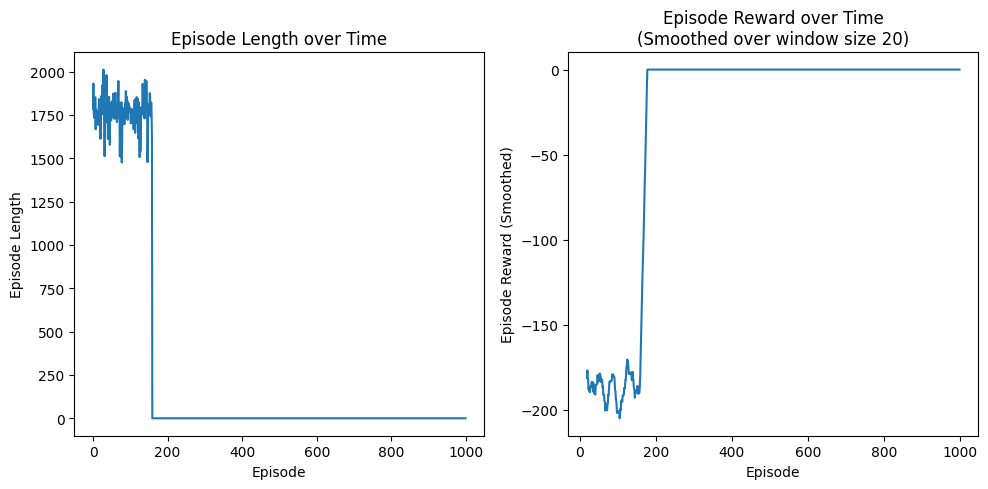

In [ ]:
smoothing_window=20

fig, axes = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)

episode_lengths =  torch.load(  f"/content/drive/MyDrive/car_racer/episode_lengths.pth"  )
episode_rewards  =  torch.load( f"/content/drive/MyDrive/car_racer/episode_rewards.pth"  )


# Plot the episode length over time
ax = axes[0]
ax.plot(episode_lengths)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Length")
ax.set_title("Episode Length over Time")

# Plot the episode reward over time
ax = axes[1]
rewards_smoothed = pd.Series(episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
ax.plot(rewards_smoothed)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Reward (Smoothed)")
ax.set_title(f"Episode Reward over Time\n(Smoothed over window size {smoothing_window})")
plt.show()
